## 0. Importing Pytorch and setting up device agnostic code

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

In [1]:
import torch
from torch import nn

torch.__version__

'2.4.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class.

Our dataset starts with 3 classes of food and only 10% of the images.

Why do this?

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary. The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory already exists...")
else:
  print(f"{image_path} does not exists, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download data
with open(data_path / "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset...")
  f.write(request.content)

# Unzip file
with zipfile.ZipFile(data_path/ "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping dataset...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exists, creating one...
Unzipping dataset...


## 2. Becoming One with the Data (Data Prepation and Data Exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [6]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing Image

1. Get all of the image paths
2. Pick a random image path using python's `random.chocie()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data/pizza_steak_sushi/train/pizza/12301.jpg
Image class: pizza
Image height: 512
Image width: 384


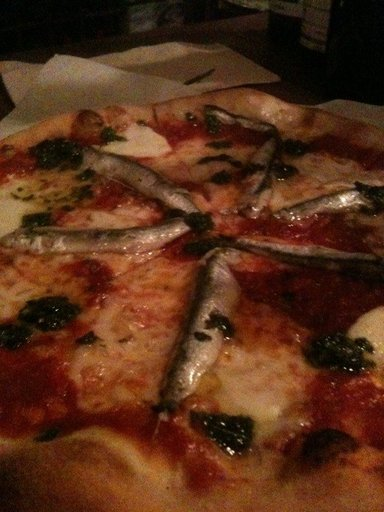

In [7]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all of the image paths
image_path_list = list(image_path.glob("*/*/*.jpg")) # we want all of them

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 383.5, 511.5, -0.5)

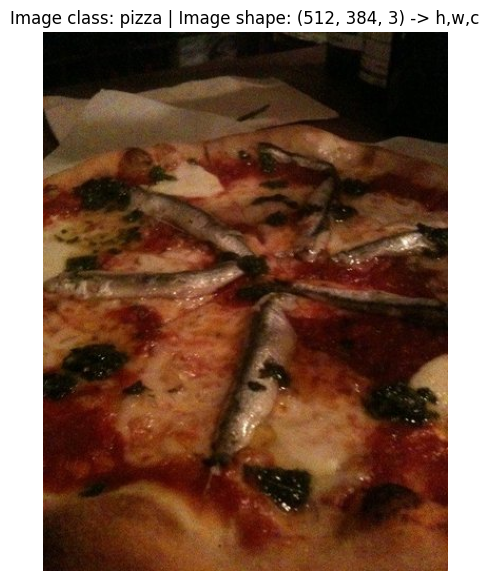

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> h,w,c")
plt.axis(False)

## 3. Transforming Data

Before we can use our image data with PyTorch:

1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn in to a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `DataLoader`.


In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used a model/perform data augmentation

`Note: 224x224 is also commanly used`

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img)

tensor([[[0.0118, 0.0157, 0.0078,  ..., 0.0118, 0.0118, 0.0078],
         [0.0118, 0.0118, 0.0078,  ..., 0.0118, 0.0118, 0.0118],
         [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0118, 0.0157],
         ...,
         [0.5137, 0.5255, 0.5373,  ..., 0.1137, 0.0980, 0.0863],
         [0.5216, 0.5333, 0.5255,  ..., 0.1255, 0.1059, 0.0902],
         [0.4941, 0.5059, 0.5059,  ..., 0.1216, 0.1098, 0.1020]],

        [[0.0157, 0.0235, 0.0157,  ..., 0.0235, 0.0196, 0.0157],
         [0.0157, 0.0196, 0.0157,  ..., 0.0196, 0.0196, 0.0196],
         [0.0196, 0.0196, 0.0196,  ..., 0.0196, 0.0196, 0.0196],
         ...,
         [0.2588, 0.2745, 0.2863,  ..., 0.0471, 0.0392, 0.0314],
         [0.2745, 0.2863, 0.2863,  ..., 0.0471, 0.0471, 0.0392],
         [0.2431, 0.2627, 0.2745,  ..., 0.0471, 0.0431, 0.0392]],

        [[0.0196, 0.0157, 0.0078,  ..., 0.0196, 0.0157, 0.0157],
         [0.0196, 0.0157, 0.0078,  ..., 0.0157, 0.0157, 0.0157],
         [0.0157, 0.0118, 0.0078,  ..., 0.0039, 0.0078, 0.

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

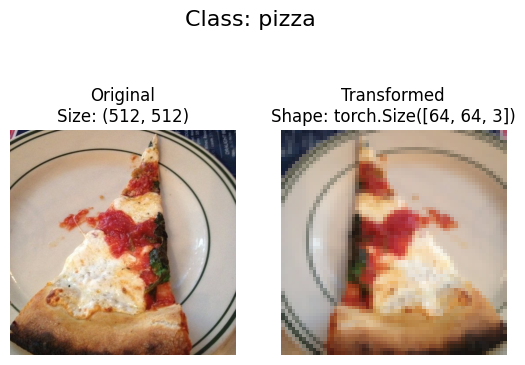

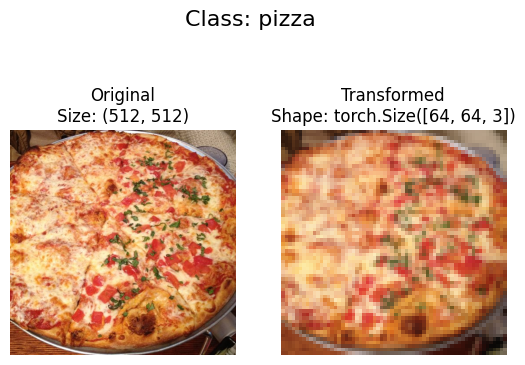

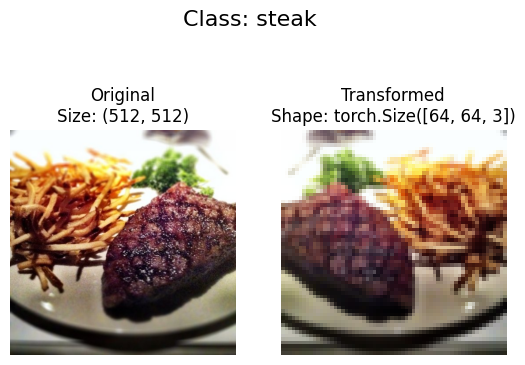

In [13]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=42):
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`


In [14]:
# Use ImageFolder to create dataset

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lenghts of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [19]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> c,h,w
Image permute: torch.Size([64, 64, 3]) -> h,w,c


Text(0.5, 1.0, 'pizza')

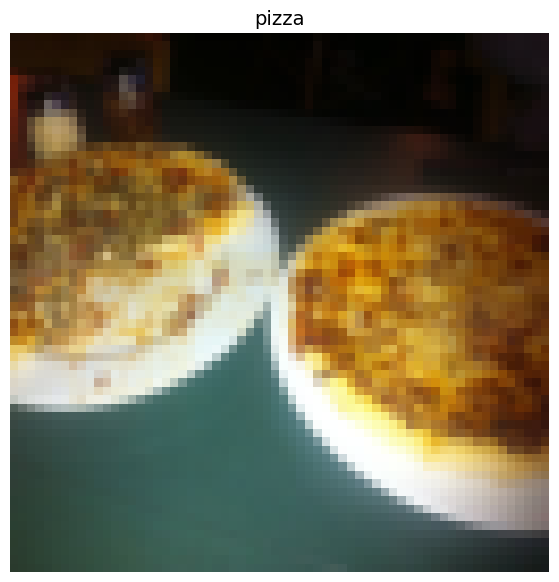

In [20]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)

# Print out different shapes
print(f"Original shape: {img.shape} -> c,h,w")
print(f"Image permute: {img_permute.shape} -> h,w,c")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

### 4.1 Turn loaded image into Dataloaders

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customise the `batch_size` images at a time.

Batch is important otherwise we can run out of memory.



In [21]:
# Turn train and test dataset into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader



(<torch.utils.data.dataloader.DataLoader at 0x78e3f5a05450>,
 <torch.utils.data.dataloader.DataLoader at 0x78e3f5a04f10>)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [bathc_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [bathc_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom Dataset

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writting more code, which could be prone to errors or performance issues.


In [24]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names aren't found.
3. Turn the class names into a dict and list and return them.



In [27]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """ Finds the classes folder names in a target directory
  """
  # 1. Get the class names by scanning the target dir
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
  # 3. Create a dictionary of index labels (for computing)
  class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init out subclass with a target directory as well as a transform if we'd like to transform our data
3. Create several attributes:
  * paths - paths of our images
  * transforms - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labes
4. Create a function to `load_images()`
5. Overwrite the `__len()__ `method
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [32]:
# Write a custom dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self,index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__
  def __len__(self) -> int:
    # Returns the total number of samples
    return len(self.paths)

  # 6. Overwrite __getitem()__ to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label(X,y)
    else:
      return img, class_idx


In [34]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [35]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [36]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x78e3f5e43670>,
 <__main__.ImageFolderCustom at 0x78e3f5e40790>)

In [37]:
len(train_data), len(train_data_custom)

(225, 225)

In [38]:
len(test_data), len(test_data_custom)

(75, 75)

In [39]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [40]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [43]:
# Check for equality between original ImageFolder and Custom
print(test_data_custom.classes==test_data.classes)

True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes from the target dataset.
5. Setup matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure dim of our iamges line up with matplotlib

In [44]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n=10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
  # 3. Set the seed
  if seed:
    random.seed(seed)
  # 4. Get random sample idx
  random_sample_idx = random.sample(range(len(dataset)), k=n)
  # 5. Setup plot
  plt.figure(figsize=(16,8))
  # 6. Loop through to idx and plot
  for i, targ_sample in enumerate(random_sample_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    # 7. Adjust tensor dim for plotting
    targ_image_adjust = targ_image.permute(1,2,0) # c,h,w -> h,w,c
    # Plot
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


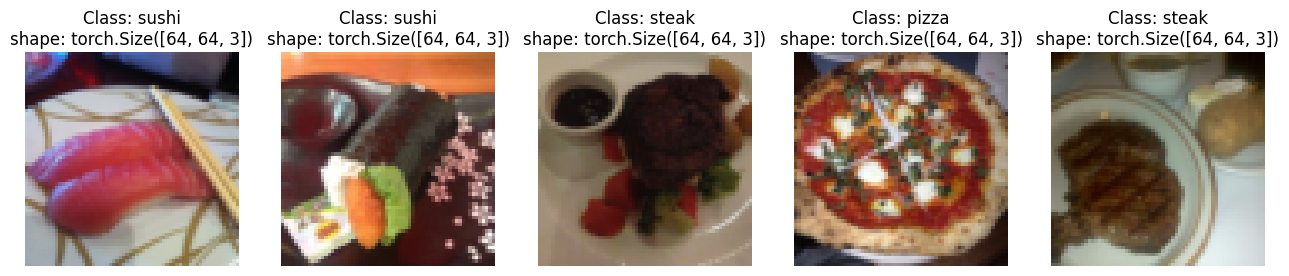

In [46]:
# Display random images form the ImageFolder created Dataset (Option 1)
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


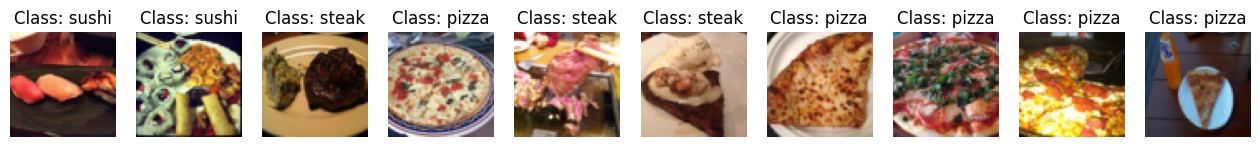

In [48]:
# Display random images form the ImageFolderCustom Dataset (Option 2)
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader` s

In [49]:
BATCH_SIZE =32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=os.cpu_count(),
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=os.cpu_count(),
                                    shuffle=False)

In [50]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x78e3f4410850>,
 <torch.utils.data.dataloader.DataLoader at 0x78e3f44116f0>)

In [51]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other Forms of Transforms (Data Augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean appliyng various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data.

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels...



In [63]:
# Let's look at TrivialAugment - leverages the power of randomness

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [64]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

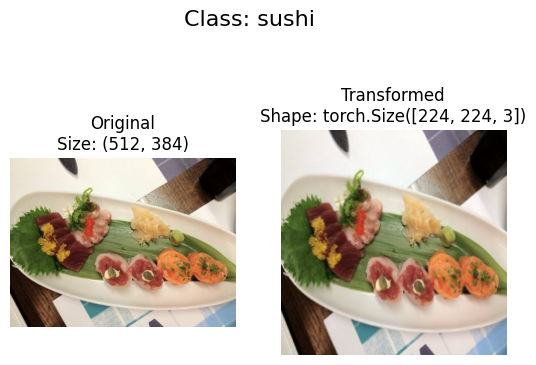

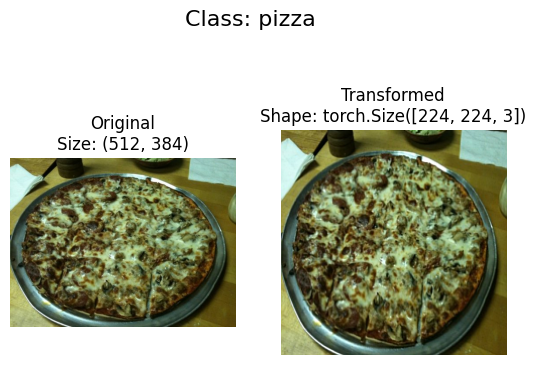

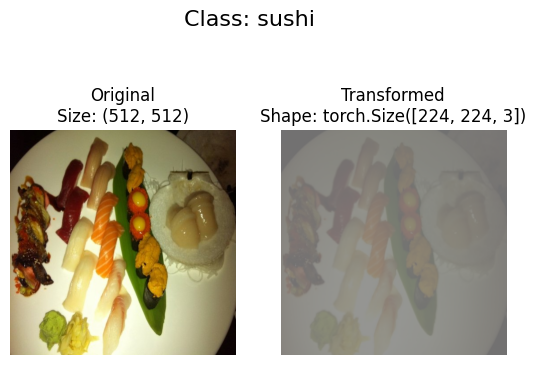

In [67]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)